In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

BASE = Path(r"C:\Users\maria\Documents\VANGUARD DATA")  # change if needed

demo = pd.read_csv(BASE / "df_final_demo_clean.csv")
exp  = pd.read_csv(BASE / "df_final_experiment_clients_clean.csv")
web  = pd.read_csv(BASE / "df_final_web_data_clean.csv")

demo["client_id"] = demo["client_id"].astype(str).str.strip()
exp["client_id"]  = exp["client_id"].astype(str).str.strip()
web["client_id"]  = web["client_id"].astype(str).str.strip()
web["process_step"] = web["process_step"].astype(str).str.lower().str.strip()
web["date_time"] = pd.to_datetime(web["date_time"], errors="coerce")

print(demo.shape, exp.shape, web.shape)

(70609, 9) (70609, 4) (744641, 6)


In [3]:
web_all = web[web["client_id"].isin(exp["client_id"])].copy()

order = ["start","step_1","step_2","step_3","confirm"]
web_all["step_order"] = pd.Categorical(web_all["process_step"], categories=order, ordered=True).codes

In [4]:
per_client = (web_all.groupby("client_id")
              .agg(events=("process_step","count"),
                   visits=("visit_id","nunique"),
                   max_step=("step_order","max"),
                   completed=("process_step", lambda s: (s=="confirm").any()))
              .reset_index())

overall_clients = len(per_client)
overall_conv = per_client["completed"].mean()

print(f"Clients in experiment (overall): {overall_clients:,}")
print(f"Overall client-level completion rate: {overall_conv:.2%}")
print(per_client[["events","visits","max_step"]].describe().round(2))

Clients in experiment (overall): 70,609
Overall client-level completion rate: 67.70%
         events    visits  max_step
count  70609.00  70609.00  70609.00
mean       6.29      1.38      3.15
std        4.04      0.83      1.41
min        1.00      1.00      0.00
25%        5.00      1.00      3.00
50%        5.00      1.00      4.00
75%        7.00      2.00      4.00
max       81.00     21.00      4.00


In [5]:
step_clients = (web_all.groupby("process_step")["client_id"]
                .nunique()
                .reindex(order, fill_value=0)
                .rename("unique_clients")
                .to_frame())

start_n = step_clients.loc["start", "unique_clients"] if "start" in step_clients.index else np.nan
step_clients["rate_vs_start"] = step_clients["unique_clients"] / start_n
step_clients["dropoff_from_prev"] = 1 - step_clients["unique_clients"].div(step_clients["unique_clients"].shift(1)).fillna(1)
step_clients = step_clients.reset_index().rename(columns={"process_step":"step"})

step_clients

,step,unique_clients,rate_vs_start,dropoff_from_prev
0,start,70014,1.000000,0.000000
1,step_1,62153,0.887722,0.112278
2,step_2,57218,0.817237,0.079401
3,step_3,53613,0.765747,0.063005
4,confirm,47800,0.682721,0.108425


In [6]:
per_visit = (web_all.groupby("visit_id")
             .agg(client_id=("client_id","first"),
                  completed=("process_step", lambda s: (s=="confirm").any()))
             .reset_index())
visit_conv = per_visit["completed"].mean()
print(f"Visits: {len(per_visit):,} | Visit completion rate: {visit_conv:.2%}")

Visits: 96,773 | Visit completion rate: 54.48%


In [7]:
w = web_all.sort_values(["visit_id","date_time"])
first_start   = w[w["process_step"]=="start"].groupby("visit_id")["date_time"].min()
first_confirm = w[w["process_step"]=="confirm"].groupby("visit_id")["date_time"].min()

ttc_minutes = ((first_confirm - first_start).dropna().dt.total_seconds() / 60).rename("ttc_min")
print("Time-to-complete (min):")
print(ttc_minutes.describe().round(2))

Time-to-complete (min):
count    45727.00
mean         6.39
std          7.41
min        -84.83
25%          2.65
50%          4.23
75%          7.33
max        300.25
Name: ttc_min, dtype: float64


In [8]:
if "age_band" not in demo.columns and "clnt_age" in demo.columns:
    demo["age_band"] = pd.cut(demo["clnt_age"], bins=[0,30,40,50,60,70,200],
                              labels=["<30","30-39","40-49","50-59","60-69","70+"], right=False)
if "tenure_band" not in demo.columns and "clnt_tenure_yr" in demo.columns:
    demo["tenure_band"] = pd.cut(demo["clnt_tenure_yr"], bins=[-0.1,2,5,200],
                                 labels=["<2 yrs","2-5 yrs","5+ yrs"])
# Who used the process?
user_ids = set(web_all["client_id"])
demo_users    = demo[demo["client_id"].isin(user_ids)].copy()
demo_nonusers = demo[~demo["client_id"].isin(user_ids)].copy()

def share(s): 
    vc = s.value_counts(dropna=False)
    return (vc / vc.sum()).round(3)

print("Gender among users:\n", share(demo_users.get("gendr", pd.Series(dtype=object))), "\n")
print("Age band among users:\n", share(demo_users.get("age_band", pd.Series(dtype=object))), "\n")
print("Tenure band among users:\n", share(demo_users.get("tenure_band", pd.Series(dtype=object))), "\n")

# Younger/older, new/long-standing (medians)
print(f"Median age — users: {demo_users['clnt_age'].median():.1f} | non-users: {demo_nonusers['clnt_age'].median():.1f}")
print(f"Median tenure (yrs) — users: {demo_users['clnt_tenure_yr'].median():.2f} | non-users: {demo_nonusers['clnt_tenure_yr'].median():.2f}")

# Conversion by age/tenure bands
per_client_demo = demo.merge(per_client[["client_id","completed"]], on="client_id", how="left")
conv_age = per_client_demo.groupby("age_band")["completed"].mean().rename("conversion").to_frame()
conv_ten = per_client_demo.groupby("tenure_band")["completed"].mean().rename("conversion").to_frame()
conv_age, conv_ten

Gender among users:
 gendr
U      0.342
M      0.336
F      0.322
NaN    0.000
X      0.000
Name: count, dtype: float64 

Age band among users:
 age_band
50-59    0.220
<30      0.188
30-39    0.186
40-49    0.176
60-69    0.169
70+      0.060
NaN      0.000
Name: count, dtype: float64 

Tenure band among users:
 tenure_band
5+ yrs     0.827
2-5 yrs    0.171
<2 yrs     0.001
NaN        0.000
Name: count, dtype: float64 

Median age — users: 47.0 | non-users: nan
Median tenure (yrs) — users: 11.00 | non-users: nan


C:\Users\maria\AppData\Local\Temp\ipykernel_15832\755601200.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conv_age = per_client_demo.groupby("age_band")["completed"].mean().rename("conversion").to_frame()
C:\Users\maria\AppData\Local\Temp\ipykernel_15832\755601200.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conv_ten = per_client_demo.groupby("tenure_band")["completed"].mean().rename("conversion").to_frame()


(          conversion
 age_band            
 <30         0.714114
 30-39       0.689309
 40-49       0.692326
 50-59       0.676135
 60-69       0.653389
 70+         0.546967,
              conversion
 tenure_band            
 <2 yrs         0.703704
 2-5 yrs        0.686709
 5+ yrs         0.674871)

In [9]:
# Overall summary
overall_summary = pd.DataFrame({
    "group": ["overall"],
    "clients":[overall_clients],
    "client_completion_rate":[overall_conv],
    "visit_completion_rate":[visit_conv],
    "median_ttc_min":[ttc_minutes.median()]
})

# Funnel by step
funnel_overall = step_clients.copy()
funnel_overall["group"] = "overall"

# Conversion by bands
conv_age2 = conv_age.reset_index().assign(group="overall")
conv_ten2 = conv_ten.reset_index().assign(group="overall")

overall_summary.to_csv(BASE / "overall_summary.csv", index=False)
funnel_overall.to_csv(BASE / "overall_funnel_by_step.csv", index=False)
conv_age2.to_csv(BASE / "overall_conversion_by_age_band.csv", index=False)
conv_ten2.to_csv(BASE / "overall_conversion_by_tenure_band.csv", index=False)

print("Saved overall tables to:", BASE)

Saved overall tables to: C:\Users\maria\Documents\VANGUARD DATA


In [10]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme()

BASE = Path(r"C:\Users\maria\Documents\VANGUARD DATA")  # change if needed

demo = pd.read_csv(BASE / "df_final_demo_clean.csv")
exp  = pd.read_csv(BASE / "df_final_experiment_clients_clean.csv")
web  = pd.read_csv(BASE / "df_final_web_data_clean.csv")

# types we rely on
for d in (demo, exp, web):
    d["client_id"] = d["client_id"].astype(str).str.strip()
web["process_step"] = web["process_step"].astype(str).str.lower().str.strip()
web["date_time"]    = pd.to_datetime(web["date_time"], errors="coerce")

# keep only experiment clients
web_all = web[web["client_id"].isin(exp["client_id"])].copy()

# fix: if a visit has no 'start', relabel its first event as 'start'
w = web_all.sort_values(["client_id","visit_id","date_time"]).copy()
has_start = w.groupby("visit_id")["process_step"].transform(lambda s: (s=="start").any())
first_in_visit = w.groupby("visit_id").cumcount().eq(0)
w.loc[(~has_start) & first_in_visit, "process_step"] = "start"

# step order for later
order = ["start","step_1","step_2","step_3","confirm"]
w["step_order"] = pd.Categorical(w["process_step"], categories=order, ordered=True).codes

In [11]:
step_clients = (w.groupby("process_step")["client_id"]
                .nunique()
                .reindex(order, fill_value=0)
                .rename("unique_clients")
                .to_frame())
start_n = step_clients.loc["start","unique_clients"]
step_clients["rate_vs_start"] = (step_clients["unique_clients"] / start_n).round(3)
step_clients

,unique_clients,rate_vs_start
process_step,,
start,70604,1.000
step_1,61796,0.875
step_2,57000,0.807
step_3,53163,0.753
confirm,47389,0.671


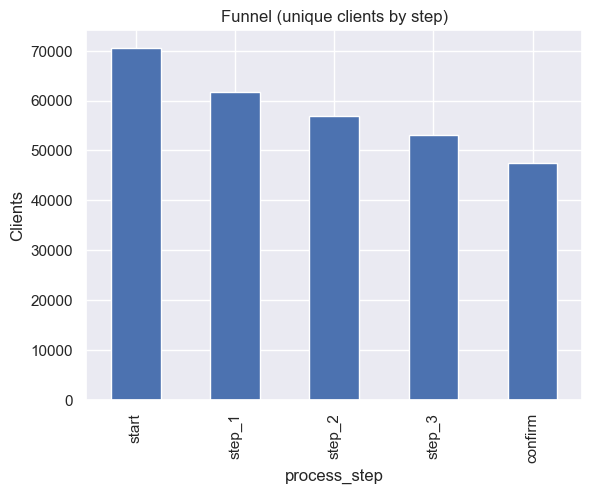

In [12]:
step_clients["unique_clients"].plot(kind="bar", title="Funnel (unique clients by step)")
plt.ylabel("Clients"); plt.show()

In [13]:
# per client
per_client = (w.groupby("client_id")
              .agg(events=("process_step","count"),
                   visits=("visit_id","nunique"),
                   max_step=("step_order","max"),
                   completed=("process_step", lambda s: (s=="confirm").any()))
              .reset_index())

client_conv = per_client["completed"].mean()
print(f"Client completion rate: {client_conv:.2%}")

# per visit
per_visit = (w.groupby("visit_id")
             .agg(client_id=("client_id","first"),
                  completed=("process_step", lambda s: (s=="confirm").any()))
             .reset_index())
visit_conv = per_visit["completed"].mean()
print(f"Visit completion rate:  {visit_conv:.2%}")

Client completion rate: 67.11%
Visit completion rate:  49.86%


In [15]:
# 1) One row per visit
visit_starts = (w.sort_values("date_time")
                  .groupby("visit_id")
                  .agg(client_id=("client_id", "first"),
                       start_time=("date_time", "first"))
                  .reset_index())

# 2) Order visits within each client by start_time
visit_starts = visit_starts.sort_values(["client_id", "start_time"])
visit_starts["visit_num"] = visit_starts.groupby("client_id").cumcount() + 1

# 3) Merge
v = per_visit.merge(visit_starts[["visit_id", "visit_num"]], on="visit_id", how="left")

# 4) Simple stats
first_rate = v.loc[v["visit_num"] == 1, "completed"].mean()
later_rate = v.loc[v["visit_num"] > 1,  "completed"].mean()
share_first = (v[(v["visit_num"] == 1) & (v["completed"])].shape[0] /
               v[v["completed"]].shape[0] if (v["completed"].any()) else 0.0)

print(f"Completion on 1st visit: {first_rate:.2%}")
print(f"Completion on later visits: {later_rate:.2%}")
print(f"Share of all completions that happen on 1st visit: {share_first:.2%}")

Completion on 1st visit: 54.93%
Completion on later visits: 36.43%
Share of all completions that happen on 1st visit: 79.97%


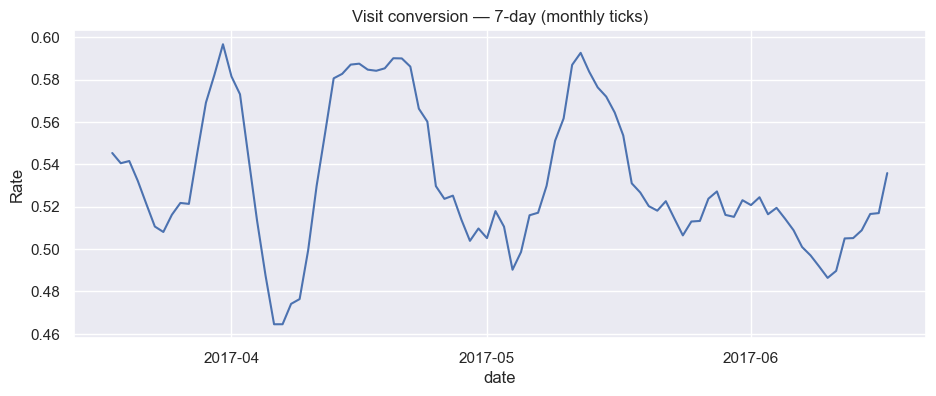

In [19]:
ax = (daily['visit_conv'].rolling(7, center=True).mean()
      .plot(figsize=(11,4)))
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title("Visit conversion — 7-day (monthly ticks)")
plt.ylabel("Rate"); plt.xlabel("date")
plt.show()

count    48179.00
mean         6.25
std          7.32
min          0.05
25%          2.53
50%          4.12
75%          7.18
max        300.25
Name: ttc_min, dtype: float64


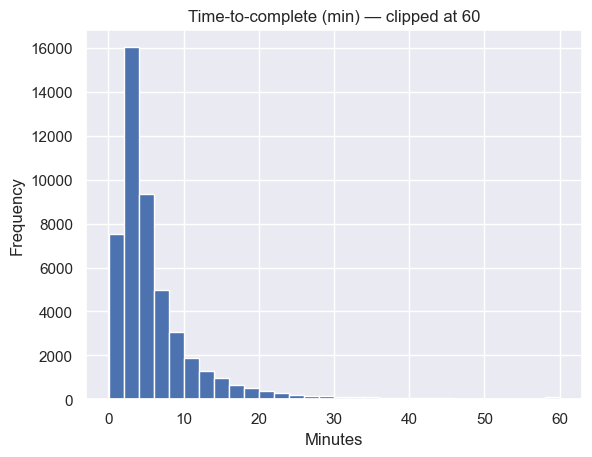

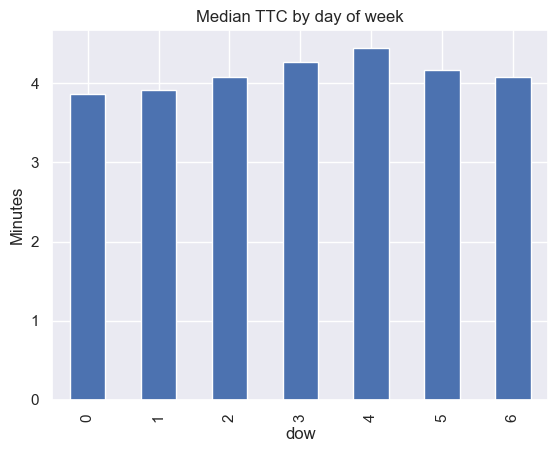

In [21]:
first_start   = w.loc[w["process_step"]=="start"].groupby("visit_id")["date_time"].min()
first_confirm = w.loc[w["process_step"]=="confirm"].groupby("visit_id")["date_time"].min()

ttc_min = ((first_confirm - first_start).dropna().dt.total_seconds() / 60)
ttc_df  = ttc_min[ttc_min >= 0].rename("ttc_min").reset_index()  # <- visit_id is a column

start_df = first_start.rename("start_time").reset_index()
wk = ttc_df.merge(start_df, on="visit_id", how="left")
wk["dow"] = wk["start_time"].dt.dayofweek  # 0=Mon ... 6=Sun

print(wk["ttc_min"].describe().round(2))

plt.figure()
wk["ttc_min"].clip(upper=60).plot(kind="hist", bins=30, title="Time-to-complete (min) — clipped at 60")
plt.xlabel("Minutes"); plt.show()

wk.groupby("dow")["ttc_min"].median().plot(kind="bar", title="Median TTC by day of week")
plt.ylabel("Minutes"); plt.show()

In [22]:
first_times = (w[w["process_step"].isin(order)]
               .groupby(["visit_id","process_step"])["date_time"].min().unstack())

# durations (min) for each transition
dur = pd.DataFrame({
    "start→1": (first_times["step_1"] - first_times["start"]).dt.total_seconds()/60,
    "1→2":     (first_times["step_2"] - first_times["step_1"]).dt.total_seconds()/60,
    "2→3":     (first_times["step_3"] - first_times["step_2"]).dt.total_seconds()/60,
    "3→confirm": (first_times["confirm"] - first_times["step_3"]).dt.total_seconds()/60
}).dropna(how="all")

dur.median().round(2)

start→1      0.27
1→2          0.45
2→3          1.27
3→confirm    1.18
dtype: float64

In [23]:
seq = (w.sort_values(["visit_id","date_time"])
         .groupby("visit_id")["process_step"]
         .apply(lambda s: " > ".join(pd.unique(s))))
top_paths = seq.value_counts().head(10)
top_paths

process_step
start > step_1 > step_2 > step_3 > confirm    45386
start                                         22389
start > step_1                                10195
start > step_1 > step_2 > step_3               9271
start > step_1 > step_2                        6246
start > confirm                                1758
start > step_2 > step_3 > confirm               468
start > step_3 > confirm                        258
start > step_2 > step_3                          78
start > step_1 > step_3 > confirm                65
Name: count, dtype: int64

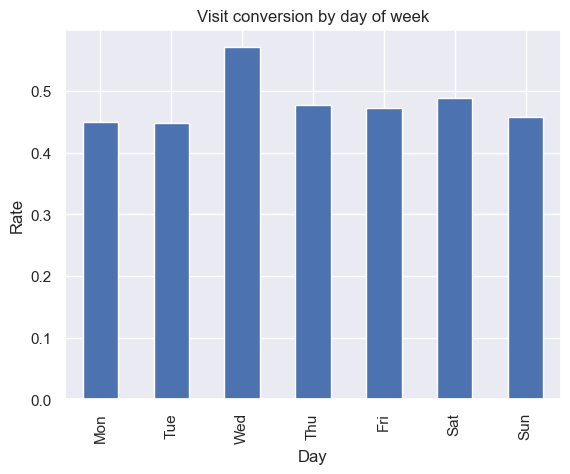

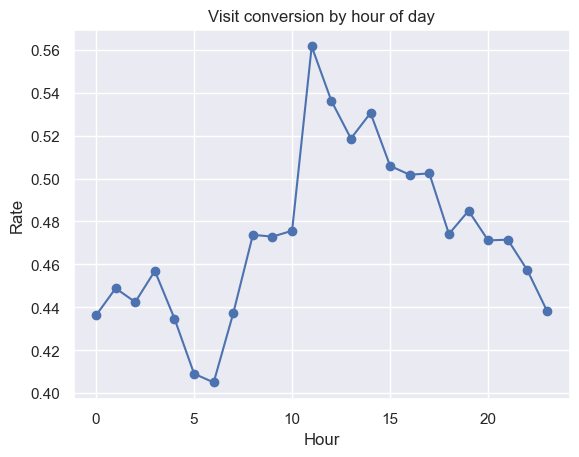

In [25]:
# One row per visit: completion flag + first timestamp
vts = (w.groupby("visit_id")
       .agg(completed=("process_step", lambda s: (s=="confirm").any()),
            dt=("date_time","min"))
       .dropna())

vts["dow"]  = vts["dt"].dt.dayofweek   # 0=Mon … 6=Sun
vts["hour"] = vts["dt"].dt.hour

# Bar chart day of the week
dow_map = {0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"}
day_conv = (vts.assign(dow_name=vts["dow"].map(dow_map))
              .groupby("dow_name")["completed"].mean()
              .reindex(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]))

day_conv.plot(kind="bar", title="Visit conversion by day of week")
plt.ylabel("Rate"); plt.xlabel("Day"); plt.show()

# Line by hour of day 
hour_conv = vts.groupby("hour")["completed"].mean()
hour_conv.plot(marker="o", title="Visit conversion by hour of day")
plt.ylabel("Rate"); plt.xlabel("Hour"); plt.show()